### Week 13. Time series data and causal inference

By Charlie Eaton, April 2020

In [1]:
%set graph_format svg

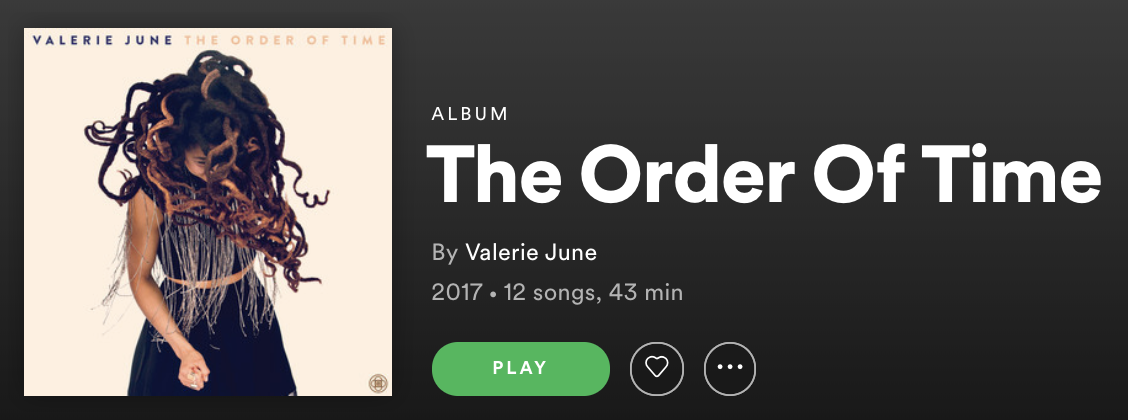

### Outline:

    A. Comparisons over time as substitutes for randomized control trials 

    B. Data carpentry: sorting / ordering data for analysis

    C. OLS Fixed effects as within-unit comparisons over time

    D. Interactions as treatment comparisons with fixed effects

    E. Logistic regression with fixed effects

    F. Time and group fixed effects

### A. Comparisons over time as substitutes for randomized control trials

Consider the use of randomized control trials if we want to test if cell immunity to Covid (DV) is **caused** by a hypothesized vaccine (IV):

1. Randomized control trials: a method to test for causal relationsips
    
2. Units (a person, animal, or material object - in this, human cell cultures) are randomly assigned to **"treatment"** and **"control"** groups.
    
3. Units assigned to the "treatment" group are "treated" with the independent variable (IV) - in this case, the vaccine. The "control" group is not treated with the vaccine.
    
4. The researcher then meaures the dependent variable (DV) of whether the cell cultures become infected when exposed to Covid for both the treatment and the control group.
    
5. Such a randomized control trial intrinsically involves a comparison over time that we can represent as hypotheses in a 2 X 2 table:

|            | Control     | Treatment  |
| ---------- |-----------| -----|
| **After**     | infection | No-infection |
| **Before**      | No-infection      |   No-infection |

A before / after approach can also provide causal insights for some observational data analysis if:

1. We have variation in our independent variables (IVs) over time

2. Independent variables (IVs) are not influenced by the dependent variables at an earlier moment in time

Use the markdown cell below to summarize the overarching hypothesis about predatory for-profit college practices from this week's "Private equity in higher education" reading:

-----
Name the dependent variable: [varname here]
Name the treatment (indepdent variable here): [varname here)

|            | Control       | Treatment  |
| ---------- |---------------| -----------|
| **After**  | [prediction]  | [prediction] |
| **Before** | [prediction]  | [prediction] |

### B. Data carpentry: sorting / ordering data for analysis

1. The intuition of time series regression techniques flows from how we sort and order the data

2. Data carpentry is the work of structuring data - including sorting and ordering

3. We sort data by time **within** each unit of analysis.

4. For example, we could sort data **by year** but **within each university** when analyzing time series data for % of university board members from high finance (DV) and university admissions rates (IV) as follows. To do so, we could use **unitid** as a **unique identifier** for each university from my board dataset.

5. Edit the sort code below to sort by year within each university and list the first 30 universities:

In [2]:
quietly {
use universityboards, clear
*log using w13lesson_timeserieslog20200422
set more off
quietly set linesize 200
}

**this is the sort code:
sort unitid year

**this lists the first 30 observations after sorting:
list unitid year schoolname pctalt acceptrate if _n<30



. sort unitid year

. list unitid year schoolname pctalt acceptrate if _n<30

      +--------------------------------------------------------------------------+
      | unitid   year                           schoolname     pctalt   accept~e |
      |--------------------------------------------------------------------------|
   1. | 104179   2003                                               .    85.0649 |
   2. | 104179   2004                                               .   83.40569 |
   3. | 104179   2005                                               .   87.69549 |
   4. | 104179   2006                 arizona state system          0   86.05576 |
   5. | 104179   2007                 arizona state system          0   77.42151 |
      |--------------------------------------------------------------------------|
   6. | 104179   2008                 arizona state system          0   80.54471 |
   7. | 104179   2009                 arizona state system          0   78.00129 |
   8. |

5. We can visually represent the data using **xtset** (which sets our systemf of sorting for analysis) and **xtline** where the **"t"** refers to time

6. For example, the following plots my DV, % high finance board members, over time for the top 30 private universities:


       panel variable:  unitid (strongly balanced)
        time variable:  year, 2003 to 2019
                delta:  1 unit


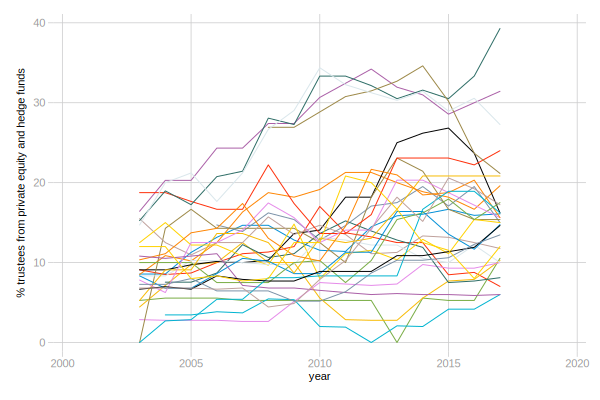

In [3]:
xtset unitid year
xtline pctalt if control==2, over legend(off) scheme(538w)
graph display

## C. OLS with fixed effects as within-unit comparisons over time

1. The fixed effect in OLS is a magical method to control for the effects of unobserved time-constant (fixed) variables for each unit of analysis. Some examples could include:
    * who a person's father or mother were
    * what city someone was born in
    * how many siblings someone had growing up
    * what city/state an organization is located in
    * unchanging differences in laws in a location where a person/organization/community is located


2. Mathematical time series symbols help to explain how:

* $ T $ is our time variable (in this case year). Particular values for $ T $ (like 2005) are represented by lowercase $ t $ 
* $ I $ is our unique identifier for each individual/unit (in this case school unitid). Particular individuals are represented by lowercase $ i $
* $ y_{it} $ is the dependent variable (% board from high finance) observed for individual $ i $ at time $ t $
* $ X_{it} $ is a vector of time-variant independent variables (like university admission rates)
* $ \beta $ is a vector of coefficients for the relationships between $ y_{it} $ and each $ X_{it} $
* $ \alpha_{i} $ is the combined effect of all time-invariant unobserved influences on $ y_{it} $ for each individual $ i $ (in our case each school)
* $ u_{it} $ is the residual (unexplained) variation in $ y_{it} $

3. OLS with fixed effect gets rid of the time invariant unobserved variables $ \alpha_{i} $ that might bias our estimates by **differencing** them out of the analysis. The procedure subtracts values for every variable in the model for individual $ i $ at time $ t $ from the mean of the variable for the individual $ i $ at all times as follows:

$$ y_{it} = {\beta}X_{it}\mathbf+\alpha_{i}+u_{it} $$

$$ y_{it}-\overline{y}_{i}={\beta}\left(X_{it}-\overline{X}_{i}\right) + \left( \alpha_{i} - \overline{\alpha}_{i} \right ) + \left(  u_{it}-\overline{u}_{i}\right)  $$

$$ y_{it}-\overline{y}_{i}={\beta}\left(X_{it}-\overline{X}_{i}\right) + \left(  u_{it}-\overline{u}_{i}\right)  $$

4. We can do this differencing procedure in Stata prior to OLS by using our sorting together with **egen**:

In [4]:
* we can do this for every variable with a forloop:
quietly foreach var in pctalt acceptrate pctunderfirst fgrnt_p /// 
logtotal03_revenue endow_assets_c_log {

* first, use egen with bysort to calculte the mean ///
* for each model variable for each unitid (school) across all years:
bysort unitid: egen m_`var'=mean(`var')

* second, subtract each observation for every i,t (unitid-year) ///
* from the mean for each variable for each i (unitid):
gen dm_`var'=`var'-m_`var'

}

5. Then we use plane old OLS to regress the differenced variables

In [5]:
est clear
*regress and store the differenced variables
quietly reg dm_pctalt dm_acceptrate dm_pctunderfirst dm_fgrnt_p ///
dm_logtotal03_revenue dm_endow_assets_c_log, robust
eststo differenced

*regress and store the undifferenced variables for comparison
quietly reg pctalt acceptrate pctunderfirst fgrnt_p  ///
logtotal03_revenue endow_assets_c_log, robust
eststo ols

6. Magically, regressing differenced variables is mathematically equivalent to including a dummy variable for each **unitid** to control for the time invariant unobserved fixed effects of that unitid:

In [6]:
*regress and store OLS using fixed effect dummy
quietly reg pctalt acceptrate pctunderfirst fgrnt_p  ///
logtotal03_revenue endow_assets_c_log i.unitid, robust
eststo dummyfixed

7. Or we can just use the stata package **xtreg** with the **fe** fixed effects specification and compare:

In [7]:
quietly xtreg pctalt acceptrate pctunderfirst fgrnt_p  ///
logtotal03_revenue endow_assets_c_log, fe robust
eststo xtreg

esttab ols differenced dummyfixed xtreg ///
, stats(r2 N, labels("R-Sqaured" "N")) cells(b(star fmt(2)) se(fmt(2) par)) stardetach  ///
legend starlevels(^ .1 * .05 ** .01 *** .001) label ///
mlabels("ols" "differenced" "dummyfixed" "xtreg") ///
collabels(none) keep(acceptrate dm_acceptrate)





----------------------------------------------------------------------------------------
                              (1)              (2)              (3)              (4)    
                              ols      differenced       dummyfixed            xtreg    
----------------------------------------------------------------------------------------
Acceptance rate             -0.19 ***                         -0.14 ***        -0.14 ***
                           (0.01)                            (0.02)           (0.03)    
dm_acceptrate                                -0.14 ***                                  
                                            (0.02)                                      
----------------------------------------------------------------------------------------
R-Sqaured                    0.49             0.13             0.87             0.13    
N                          846.00           846.00           846.00           846.00    
-----------------

### D. Interactions as treatment comparisons with fixed effects

1. We cannot use fixed effects for time-invariant variables using fixed effects such as:
* state vs. private ownership of a university
* race and sex

2. But we can use interactions with fixed effects to see if our dependent variable (DV) is affected differently by an independent variable across time-invariant categories such as:
* The effect on wages of education by race/gender
* The effect on %board from high finance of admission rates by state vs private ownership

3. Here is how we would impliment that in Stata:

In [8]:
quietly xtreg pctalt i.control##c.acceptrate pctunderfirst fgrnt_p  ///
logtotal03_revenue endow_assets_c_log, robust fe

est sto interacted

esttab ols differenced dummyfixed xtreg interacted ///
, stats(r2 N, labels("R-Sqaured" "N")) cells(b(star fmt(2)) se(fmt(2) par)) stardetach  ///
legend starlevels(^ .1 * .05 ** .01 *** .001) label ///
mlabels("ols" "differenced" "dummyfixed" "xtreg" "interacted") ///
collabels(none) keep(acceptrate dm_acceptrate 1.control#c.acceptrate 2.control#c.acceptrate) modelwidth(10)





-----------------------------------------------------------------------------------------------
                            (1)            (2)            (3)            (4)            (5)    
                            ols     differen~d     dummyfixed          xtreg     interacted    
-----------------------------------------------------------------------------------------------
Acceptance rate           -0.19 ***                     -0.14 ***      -0.14 ***      -0.02    
                         (0.01)                        (0.02)         (0.03)         (0.03)    
dm_acceptrate                            -0.14 ***                                             
                                        (0.02)                                                 
Public # Acceptanc~e                                                                   0.00    
                                                                                        (.)    
Private not-for-pr~a                

------

### What are some interactions you could test with fixed effects in your own research?

### E. Logistic regression with fixed effects

1. Fixed effects get tricky with logistic regression because we need variation in the dependent variable within each individual

2. Individuals without variation in the dependent variable are dropped

3. Alternatives to fixed effects logistic regression for time series analysis with dichotomous dependent variables are hazard models, survival models, and Cox models

4. Logistic regression is specified with **xtlogit** in Stata with similar syntax to **xtreg** and outputs odds ratios.

### F. Time and group fixed effects

1. Fixed effects can also be used to control for unobserved factors related to an observation occuring within a known group. Examples of groupings we often know are:
* Years
* State or other locations
* Class rooms

2. Adding **time** fixed effects can reduce bias from some **time variant** unobserved factors (as opposed to time invariant unobserved factors addressed by xtreg with fe)

3. To add such time fixed effects, we add a dummy variable using the **i.** prefix before an time identifying variable

4. For example, the following adds a year fixed effect to the model.

5. The time fixed effects rarely have any meaning, so we exclude them from the table of our regression estimates (I exclude unmeaningful coefficients for control variables from regression tables):

In [9]:
xtreg pctalt i.control##c.acceptrate pctunderfirst fgrnt_p  ///
logtotal03_revenue endow_assets_c_log i.year, robust fe

est sto yeareffects

esttab ols differenced dummyfixed xtreg interacted yeareffects ///
, stats(r2 N, labels("R-Sqaured" "N")) cells(b(star fmt(2)) se(fmt(2) par)) stardetach  ///
legend starlevels(^ .1 * .05 ** .01 *** .001) label ///
mlabels("ols" "differenced" "dummyfixed" "xtreg" "interacted") ///
collabels(none) keep(acceptrate dm_acceptrate 1.control#c.acceptrate 2.control#c.acceptrate) modelwidth(8)


note: 2.control omitted because of collinearity

Fixed-effects (within) regression               Number of obs     =        846
Group variable: unitid                          Number of groups  =         60

R-sq:                                           Obs per group:
     within  = 0.2033                                         min =          8
     between = 0.2415                                         avg =       14.1
     overall = 0.1550                                         max =         15

                                                F(20,59)          =       3.93
corr(u_i, Xb)  = -0.7570                        Prob > F          =     0.0000

                                           (Std. Err. adjusted for 60 clusters in unitid)
-----------------------------------------------------------------------------------------
                        |               Robust
                 pctalt |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
--------------